In [2]:
import os 
import sys
import re 
import numpy as np
import agilent_loader as ag
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import warnings
import PyMi as pmi
import pandas as pd

folder = "datos2\silicon"

results_folder = folder+"\\Results"

pmi.check_and_prepare_folder(results_folder)

files_in_folder = pmi.get_mi_files_in_folder(folder)

print(f" Found {len(files_in_folder)} files in {folder}")


Folder 'datos2\silicon\Results' already exists and is now empty.
 Found 2 files in datos2\silicon


k_l: 4.50e-01 N/m
lateral_slope: 4.00e+07 V/m
conversion_factor_alpha: 1.13e-08 N/V
Normal force: 1.39e+01 nN
[[0.00732422 0.00717163 0.00762939 ... 0.00762939 0.00778198 0.00778198]
 [0.00732422 0.00793457 0.00823975 ... 0.00747681 0.00747681 0.00808716]
 [0.00732422 0.00747681 0.00686646 ... 0.00778198 0.00778198 0.00839233]
 ...
 [0.01052856 0.00793457 0.00839233 ... 0.00808716 0.00762939 0.00747681]
 [0.00900269 0.0088501  0.00854492 ... 0.00778198 0.00717163 0.00823975]
 [0.0088501  0.00915527 0.00839233 ... 0.00793457 0.00854492 0.00747681]]
<class 'NoneType'>
[[0.00732422 0.00717163 0.00762939 ... 0.00762939 0.00778198 0.00778198]
 [0.00732422 0.00793457 0.00823975 ... 0.00747681 0.00747681 0.00808716]
 [0.00732422 0.00747681 0.00686646 ... 0.00778198 0.00778198 0.00839233]
 ...
 [0.01052856 0.00793457 0.00839233 ... 0.00808716 0.00762939 0.00747681]
 [0.00900269 0.0088501  0.00854492 ... 0.00778198 0.00717163 0.00823975]
 [0.0088501  0.00915527 0.00839233 ... 0.00793457 0.00854

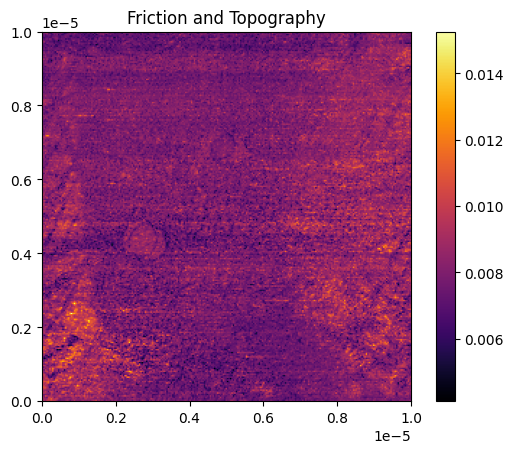

finding conversion factor
graphing topography
2 1
1 scale length 1
showing


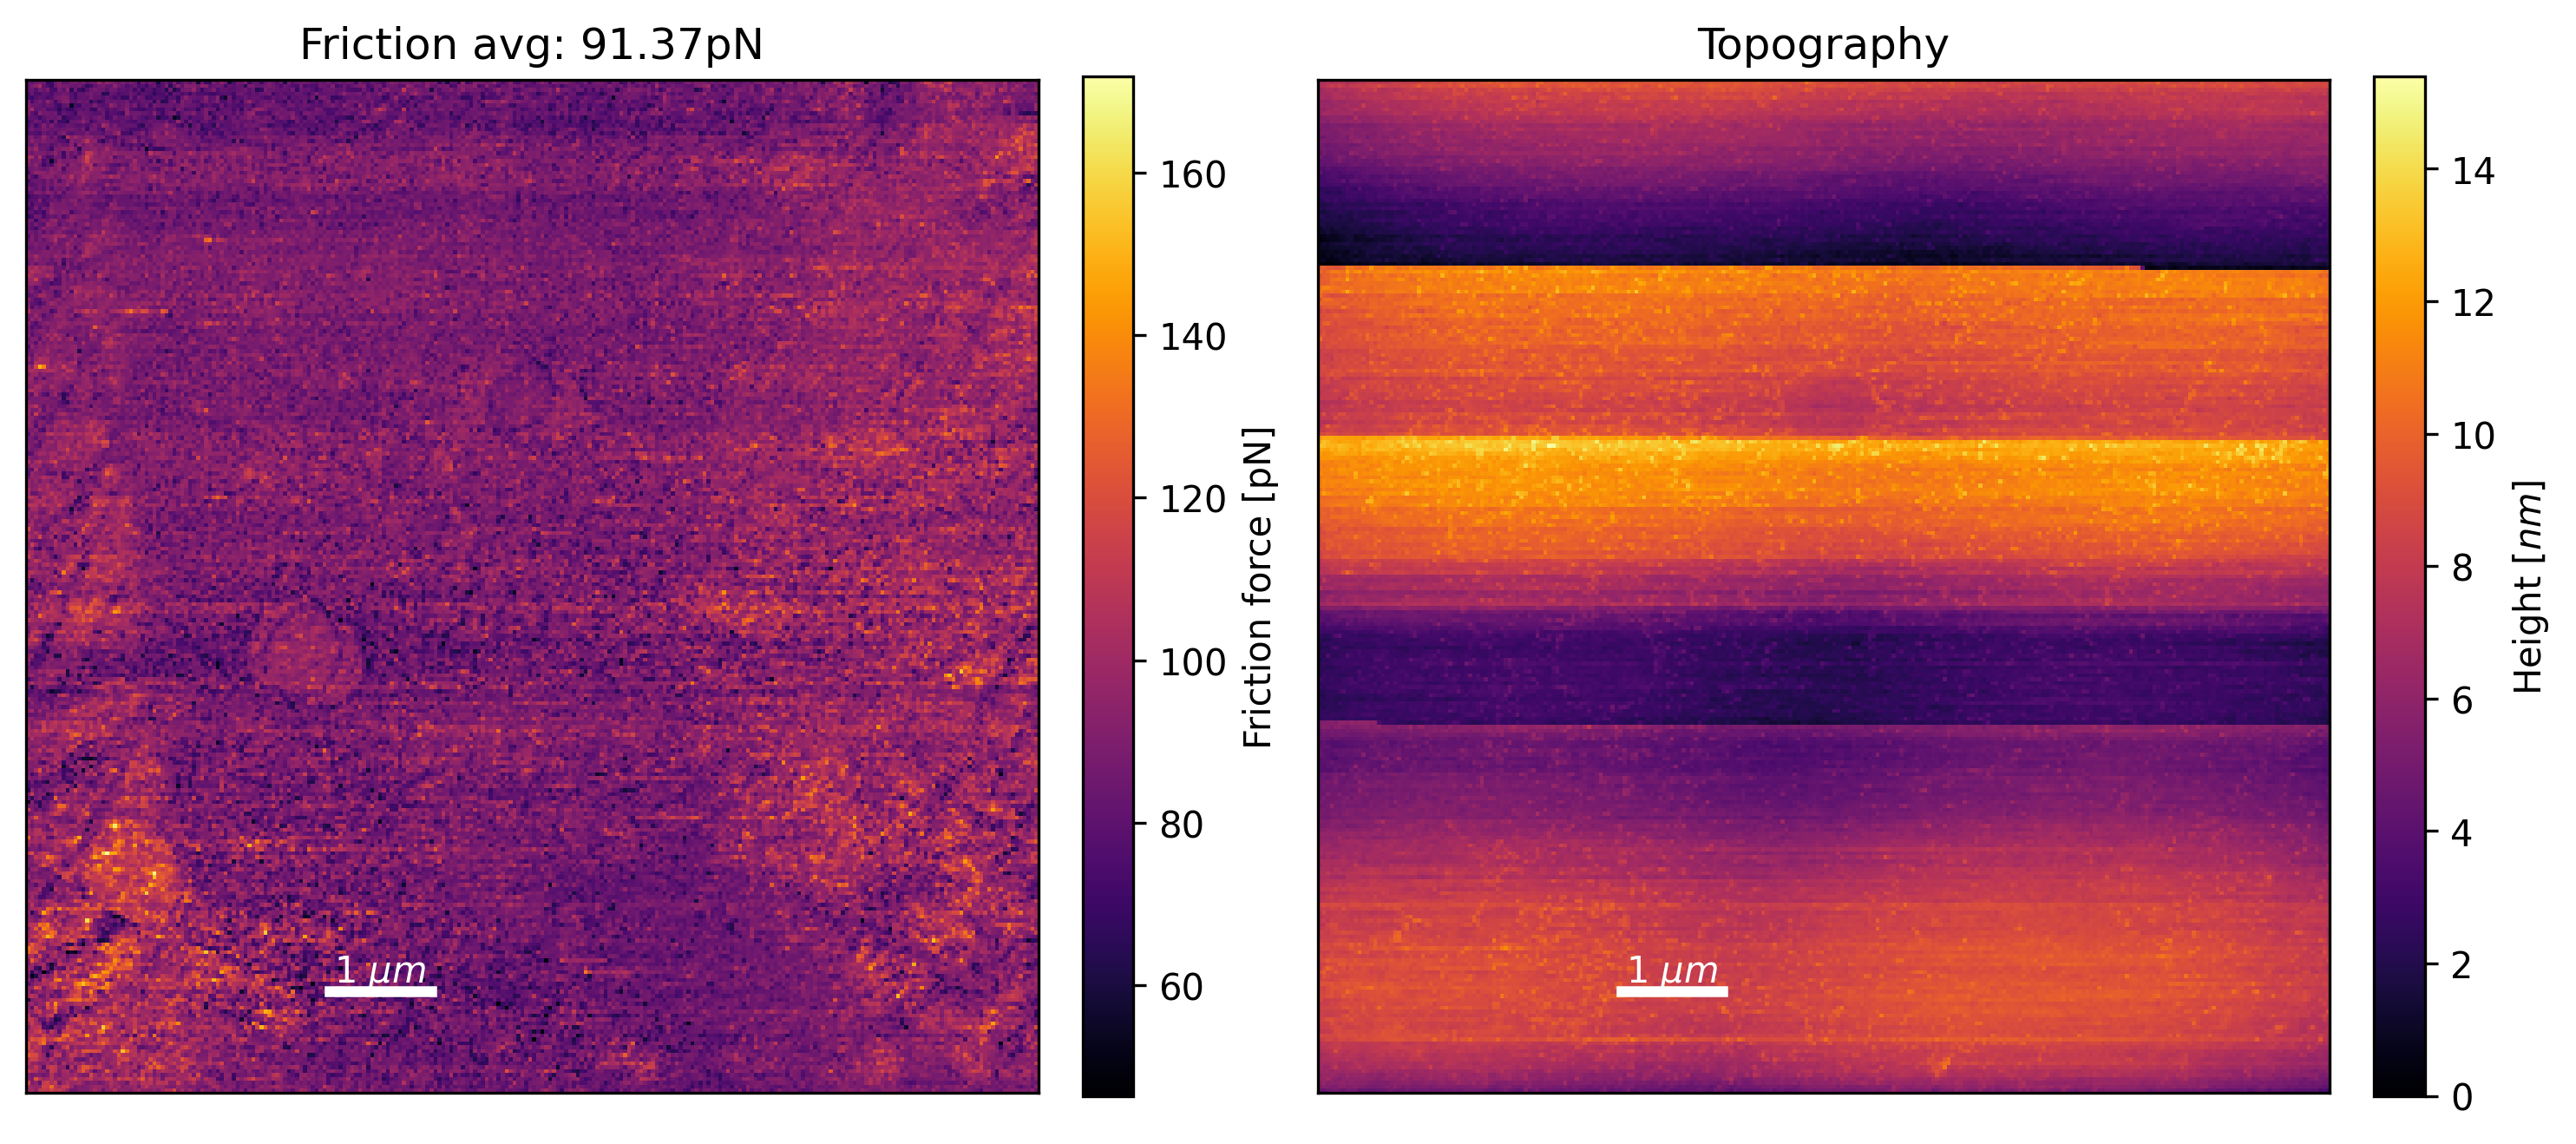

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'NoneType'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


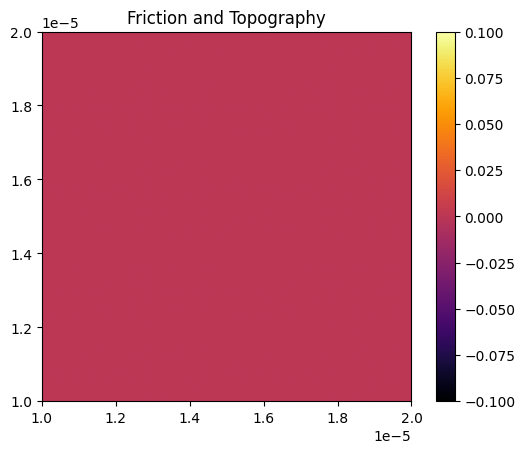

finding conversion factor
graphing topography
2 1
1 scale length 1
showing


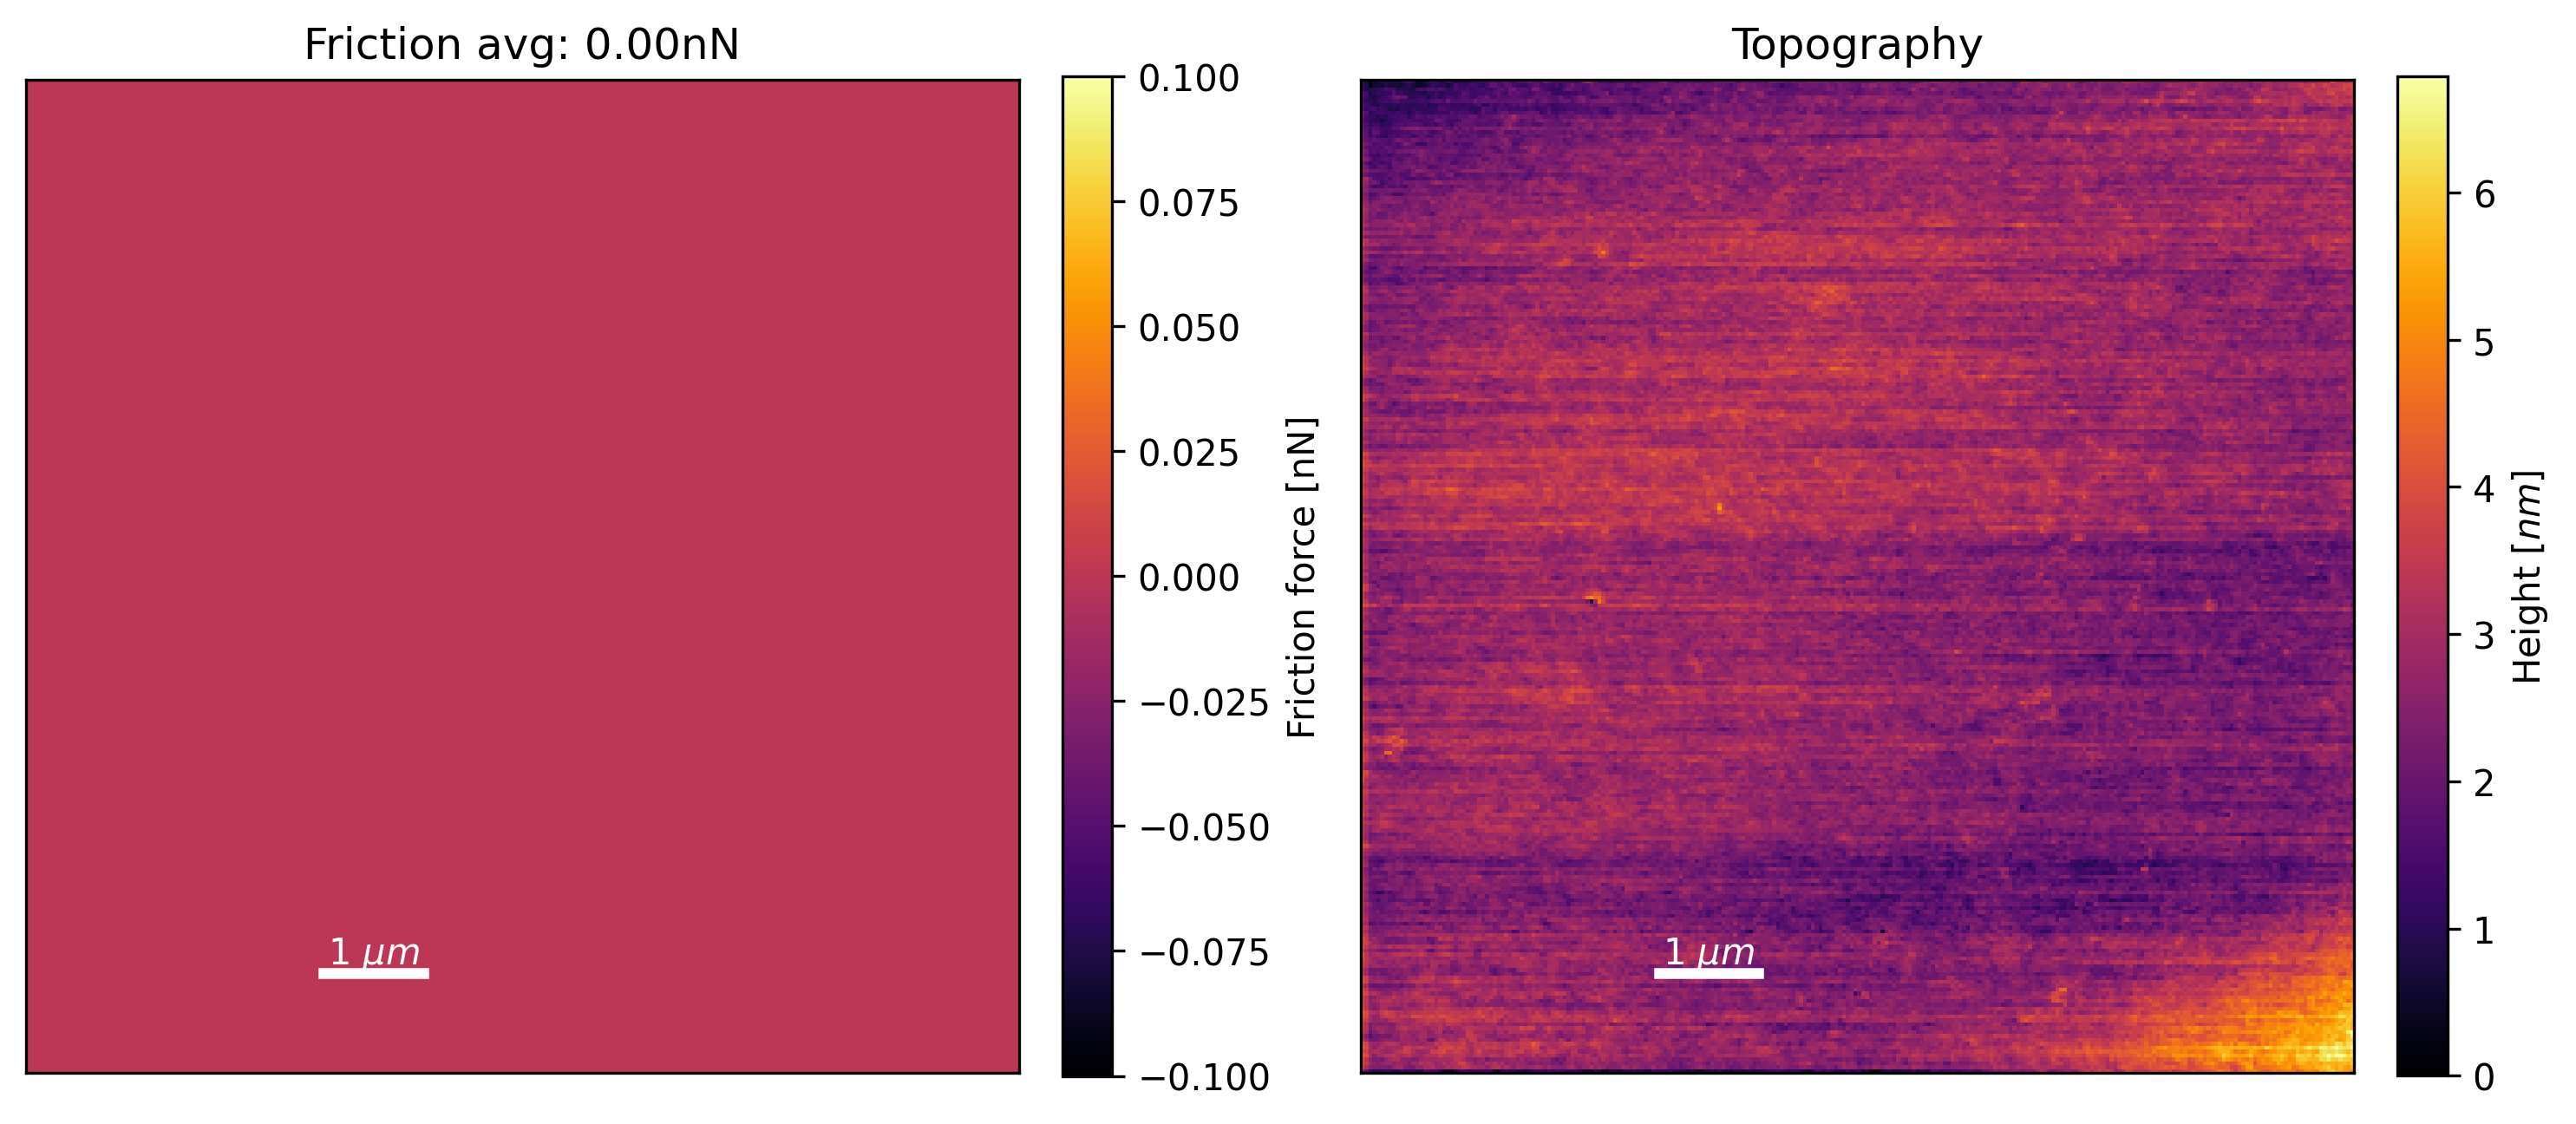

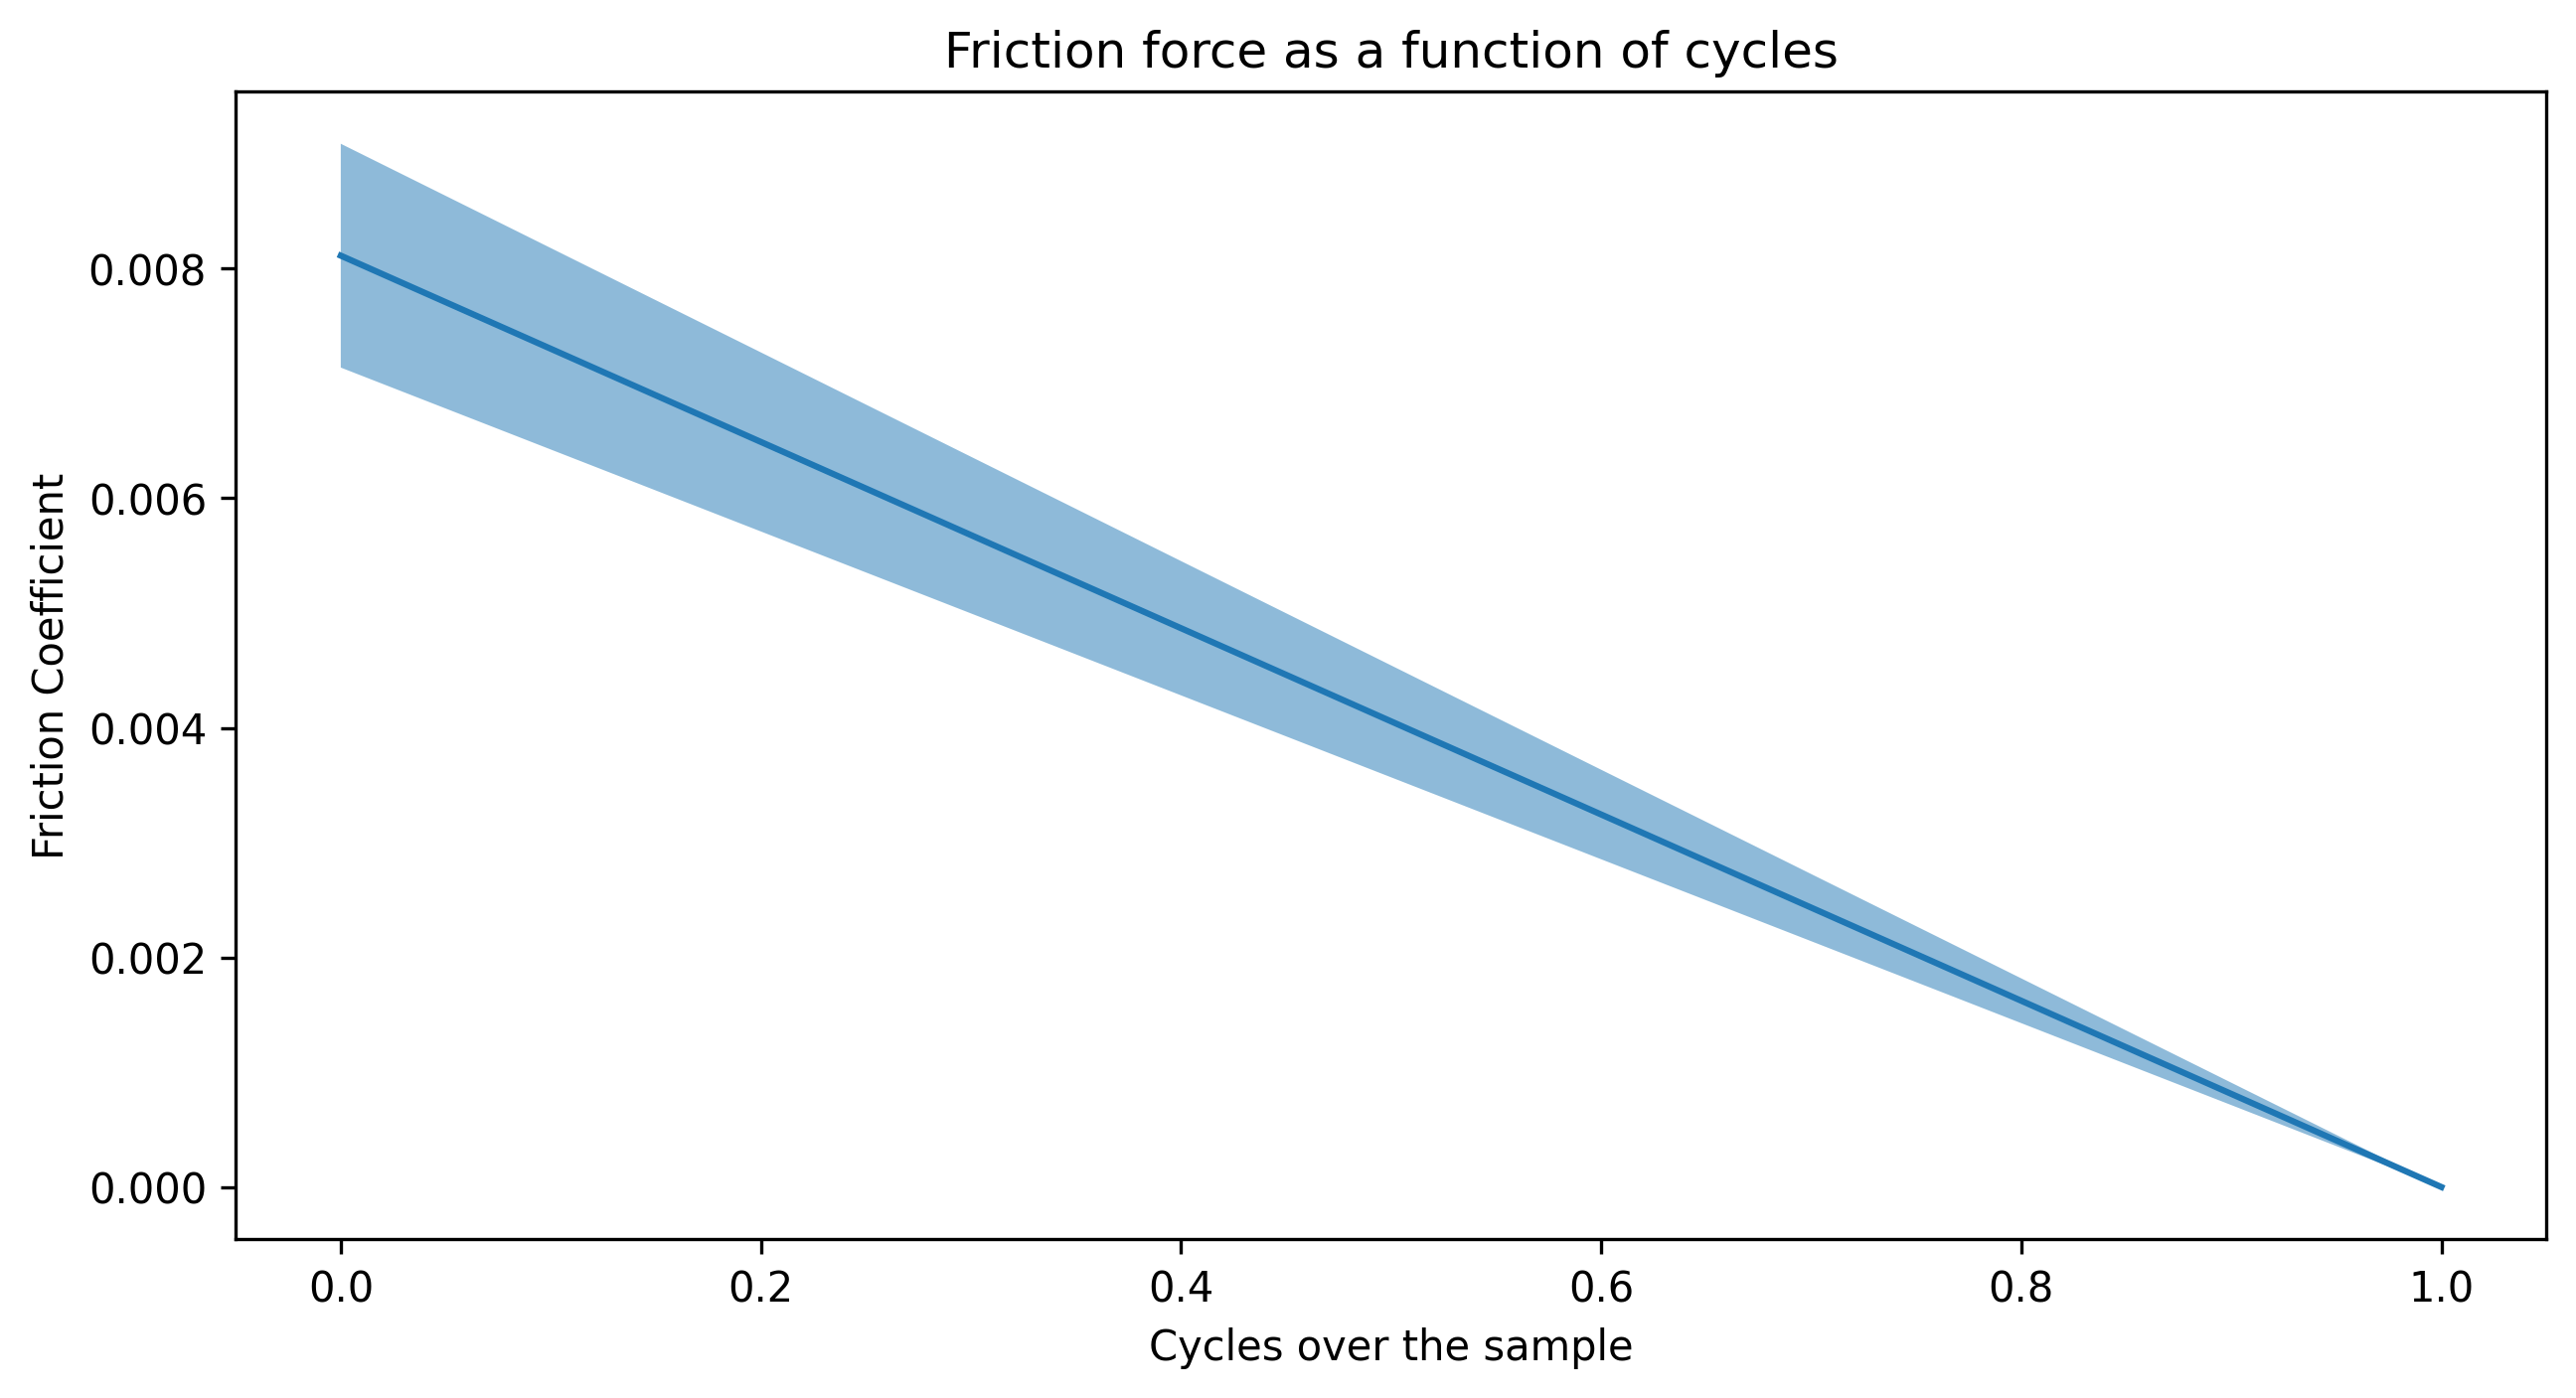

In [31]:
Cof_for_runs=np.zeros(len(files_in_folder))
Cof_for_runs_std=np.zeros(len(files_in_folder))
Normal_forces=np.zeros(len(files_in_folder))
ii=0


canteliever_length=450e-6	#[m]
# canteliever_width=50		#[um]
# canteliever_height=15e-3	#[um]
poisson_ratio=0.27


spring_constant=0.234	#[N/m]
InVOLS=115				#[nm/V]
# lateral_sensitivity=25e-9	#[m/V]


kappa=1.11e-10	#[N/m]
h=15e-6			#[m]
L=450e-6		#[m]
L_prime=430e-6	#[m]

lateral_slope=(1/25)*1e9		#[V/m]
normal_slope=1/InVOLS			#[V/nm]	

k_l=kappa*(L_prime/L)*(L_prime/L)/(h**2)	#[N/m]
k_n=0.234						#[N/m]

theta=np.deg2rad(15)	#[rad]

conversion_factor_alpha=k_l/lateral_slope	#[N/V]

print(f'k_l: {k_l:.2e} N/m')
print(f'lateral_slope: {lateral_slope:.2e} V/m')
print(f'conversion_factor_alpha: {conversion_factor_alpha:.2e} N/V')

conversion_factor_betta=k_n/(normal_slope*np.cos(theta))	#[N/V]



#!↑↑↑ This is the formula for the lateral spring constant, for the Sader and Green methods

slope_m=21941.0186	#[V/m]
stiffness=0.03238	#[N/m]
#!↑↑↑ For the magic carpet method, the formula is:
magic_conversion_factor=stiffness/slope_m #[N/V]






scale_length=1

multiple_files=False
if len(files_in_folder)>2:
	multiple_files=True


for file_path in files_in_folder:
	
	file=ag.load_mi(folder+"\\"+file_path)	
	
	
	Normal_force=conversion_factor_betta*file.servoSetpoint

	if (ii==0): print(f"Normal force: {Normal_force:.2e} nN")
	Normal_forces[ii]=Normal_force



	results_buffers= pmi.load_buffers_from_file(file)
	# print(len(results_buffers))
	if len(results_buffers)==2:
		friction_arrays,topography_arrays=results_buffers
	if len(results_buffers)==3:
		friction_arrays,topography_arrays,current_arrays=results_buffers

	averaged_friction,Cof_for_runs[ii],Cof_for_runs_std[ii]=pmi.calculate_CoF(friction_arrays,file_path,
																			# conversion_factor_gamma/Normal_force,
																		   )
		
	if (ii==0) or not multiple_files :
		
		pmi.graph_friction_n_topography( 
								file=file,
								averaged_friction=averaged_friction,
								topography=topography_arrays[0],
								results_folder=results_folder,
								file_path=file_path,
								title="Friction and Topography", 
								show=True, 
								scale_length=scale_length,
								friction_color_range=4,
								bar_position=(0.3,0.1), 
								scale_unit="um",
								axis_ticks=False,
								# conversion_factor=magic_conversion_factor
								conversion_factor=conversion_factor_alpha
								)
	ii+=1
		


if multiple_files or True:

	pmi.plot_CoF(Cof_for_runs,Cof_for_runs_std,results_folder, show=True)


df=pd.DataFrame(data={"File":files_in_folder,"Cof":Cof_for_runs,"Cof_std":Cof_for_runs_std})

df.to_csv(results_folder+"\\Cof_results.csv",index=False, float_format="%.12f")



In [29]:

lateral_slope=(1/25)
print(f"k_l: {k_l:.2e} N/m")
print(f'lateral_slope: {lateral_slope:.2e} V/nm')
conversion_factor_alpha=k_l/(lateral_slope)
print(f"conversion_factor_alpha: {conversion_factor_alpha:.2e} nN/V")

lateral_slope=(1/25)*1e9	#[V/nm]
conversion_factor_alpha=k_l/(lateral_slope)	#[N/V]
print(f"k_l: {k_l:.2e} N/m")
print(f'lateral_slope: {lateral_slope:.2e} V/nm')
print(f"conversion_factor_alpha: {conversion_factor_alpha:.2e} nN/V")

k_l: 4.50e-01 N/m
lateral_slope: 4.00e-02 V/nm
conversion_factor_alpha: 1.13e+01 nN/V
k_l: 4.50e-01 N/m
lateral_slope: 4.00e+07 V/nm
conversion_factor_alpha: 1.13e-08 nN/V
